In [3]:
def getfisher(R, TISSUES):
    O=defaultdict(list)
    Mapdata = {}
    Motifs = list(set(list(R.loc[R['E.tissues']>=1]['motif'])))
    for tis in TISSUES:
        #Review motif policies here
        field= 'eSTR.'+SHORTEN[tis]
        # Focus on estrs and motifs
        data = R[["gene","chrom", "str.start","motif",field]]#,"best.score","best.tissue","INTRON"]]
        data_e = data.loc[data[field]>0]
        #
        #frequent_motifs estrs
        Mo_counts=[list(data['motif']).count(x) for x in Motifs]
        Estr = data_e.shape[0]
        Str = data.shape[0]
        All = []
        # Fisher test for each motif
        for M in Motifs:
            data_eM = data_e.loc[data_e['motif']==M]
            data_M = data.loc[data['motif']==M]
            Mestrs = data_eM.shape[0]
            Mstrs = data_M.shape[0]
            CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
            oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])                             #Fisher
            #print ("P (", M, ")    ~~   ",pv*100,"%     with    OR=", oddsratio)
            All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
            O[M].append(oddsratio)
            #
        Mapdata[tis]=All
    #Selecting motifs present in all tissues
    Mset = []
    for o in O.keys():      # O has all the motifs and occurence in tissues
        if len(O[o])>=len(TISSUES):
            Mset.append(o)
    print(len(Mset))
    #heatmap matix
    pdata = np.zeros((len(TISSUES), len(Mset)))
    for i in range(len(TISSUES)):
        T = TISSUES[i]
        for j in range(len(Mset)):
            m=Mset[j]
            val = [s[2] for s in  Mapdata[T] if s[0]==m ]
            if val==[]:
                pdata[i][j] =0
            else:
                pdata[i][j] =val[0]
    return Mset, O,Mapdata, pdata


def fisher(x):
    vals =[x[0], x[1],x[2],x[3]]
    o,p = ss.fisher_exact([[vals[0],vals[1]],[vals[2],vals[3]]])
    return o,p

def plotmotifenrichmentatTF(TF):
    print(TF)
    transfacts = [x for x in os.listdir(TFs) if TF in x][0]  #
    mytf = TFs+transfacts  

    #get all overlaps
    cmd = "bedtools intersect -a all_analyzed_strs.bed -b %s > Intersect.bed"%mytf
    returned_value = os.system(cmd)
    Inter = pd.read_csv('Intersect.bed', sep='\t', header=None, names=["chrom","start","end"])
    Feature_strs = list(set(Inter.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1)))
    #Look at eSTRs overlaps 
    all_strs = pd.read_csv(REGRSSION, sep='\t')
    all_strs = all_strs[np.isfinite(all_strs['str.start'])] #Just in case we have NA here. shouldn't
    all_strs['str.start']=all_strs['str.start'].astype(int)
    all_strs['loci'] = all_strs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)
    data = all_strs.loc[all_strs['loci'].isin(Feature_strs)].copy()
    #Causal
    merged = pd.read_csv(MERGEFILE, sep="\t")
    merged['str.start'] = merged['best.str.start']
    merged = merged[np.isfinite(merged['str.start'])]; merged['str.start'] = merged['str.start'].astype(int) 
    merged['loci'] = merged["chrom"]+":"+merged["str.start"].astype(str)
    merged['causal'] = merged['top.variant'].apply(lambda x: 1 if "STR" in x else 0)
    #######
    A = data[["loci","gene","chrom","str.start","E.tissues","motif", "period"]]       #all strs
    B = merged[["gene", "loci","causal","top.variant","best.tissue", "NumTissues"]]   #all strs and causal score
    C = pd.merge(A,B, on=["gene","loci" ],how='left')                                 #merge for causal scores
    D = C.copy()                  #                                                   #get overlaps with TFs
    #######
    motifs = list(set(list(D["motif"])))
    cont_table = pd.DataFrame({"motifs":motifs, "total.count":[list(D["motif"]).count(x) for x in motifs] })
    ##Fisher
    #estr enrichment
    estr = D.loc[D['E.tissues']>=1]
    cont_table["estr.count"] = [ list(estr['motif']).count(x) for x in motifs  ]
    cont_table["enonmotif"] = -cont_table["estr.count"]+estr.shape[0]
    cont_table["nonemotif"] = cont_table['total.count']-cont_table["estr.count"]
    cont_table["none.nonm"] = D.shape[0] - estr.shape[0]-cont_table["nonemotif"]
    cont_table['e.fisher'] = cont_table[["estr.count","enonmotif","nonemotif","none.nonm"]].apply(lambda x: fisher(x),1)
    cont_table["estr.odd"] = cont_table['e.fisher'].apply(lambda x: x[0])
    cont_table["estr.pval"] = cont_table['e.fisher'].apply(lambda x: -np.log10(x[1]))

    #Causal enrichment
    causal = estr.loc[estr["causal"]==1 ]
    cont_table["causal.count"] = [list(causal["motif"]).count(x) for x in motifs]
    cont_table["Cnonmotif"] = -cont_table["causal.count"]+estr.shape[0]
    cont_table["nonCmotif"] = cont_table['total.count']-cont_table["causal.count"]
    cont_table["nonC.nonm"] = D.shape[0] - causal.shape[0]-cont_table["nonCmotif"]
    cont_table['c.fisher'] = cont_table[["causal.count","Cnonmotif","nonCmotif","nonC.nonm"]].apply(lambda x: fisher(x),1)           
    cont_table["causal.odd"] = cont_table['c.fisher'].apply(lambda x: x[0])
    cont_table["causal.pval"] =cont_table['c.fisher'].apply(lambda x: -np.log10(x[1]))

    print("All STRs: ",A.shape[0], "\tAll TFs STRs: ",D.shape[0], "\tAll eSTRs: ",estr.shape[0],"\tAll Causal: ", causal.shape[0])
    cont_table.index=list(cont_table['motifs'])
    df = cont_table[['estr.pval','causal.pval']]; df.index = list(cont_table['motifs'])

    #plot
    ax = df.plot(figsize=(15, 6))
    ax.set_xticks([x for x in range(1,len(df.index)+1, 1)])
    ax.set_xticklabels(df.index, rotation=90)
    plt.xlabel('Motifs', fontsize=10)
    plt.ylabel('Enrichment\n-log10(pvalue)', fontsize=10)
    plt.title("Motif enrichment at eSTR ovelapping TFs %s"%TF)
    fig.savefig(os.path.join(OUTPATH, "%s_eSTRs_Motif_enrichment-at_%s.pdf"%(PREFIX,TF)))
    plt.show()
    #print (df.T)
    return(data)

In [7]:
# Set up
%store -r
%pylab inline
"""
Here i want to look at TF of interest individually 
Plot motif enrichment for eSTRs and causal at TFs
"""
# Libraries
from collections import defaultdict
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn as sns

OUTPATH = "../pdfs"
PREFIX = "SupllFigure2" # Keep as a variable in case we move things around!

#variables
SHORTEN
COLORS
TISSUES
#
#TISSUES = sorted([item for item in list(SHORTEN.keys()) if item not in['LCL','permuted']])
MERGEFILE = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
REGRSSION = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
OUTDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
TFs = '/storage/mgymrek/gtex/tfbs/encodedata/'

Populating the interactive namespace from numpy and matplotlib


In [8]:
%%bash
# Get all STRs analyzed
BASEDIR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue
cat ${BASEDIR}/Merged_Best_causality.Table | grep -v gene | awk '{print $2 "\t" $3+0 "\t" $3+2}'|sort | uniq >all_analyzed_strs.bed

POLR2AphosphoS5
All STRs:  6280 	All TFs STRs:  6280 	All eSTRs:  1844 	All Causal:  573


NameError: name 'fig' is not defined

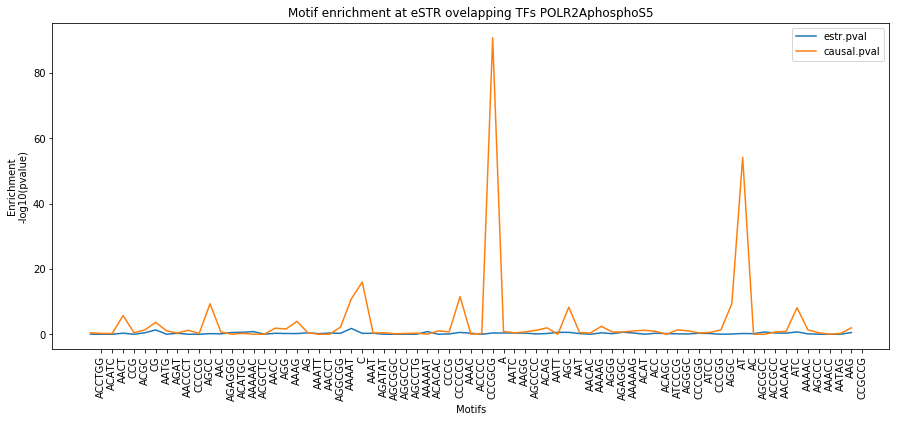

In [10]:
TF = 'POLR2AphosphoS5'                                           #####  Transcription factor of interest
transfacts = [x for x in os.listdir(TFs) if TF in x][0]  #
mytf = TFs+transfacts
polr2 = plotmotifenrichmentatTF(TF)

POLR2A
All STRs:  1289 	All TFs STRs:  1289 	All eSTRs:  318 	All Causal:  75


NameError: name 'fig' is not defined

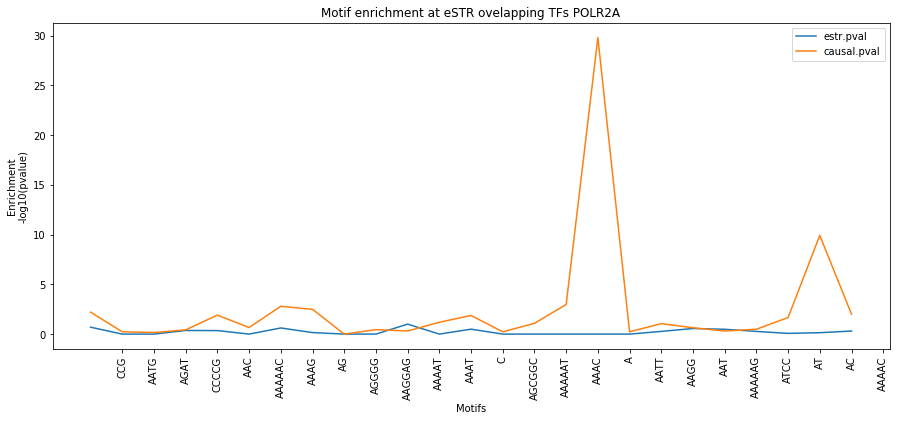

In [11]:
tfs = ['POLR2A','POLR2AphosphoS2','H3K79me2',"H3K4me3","H2AF2","MLLT1",'NRF1', 'NR2F1','CHD1']
for TF in tfs:
    data = plotmotifenrichmentatTF(TF)

GATAD2B
All STRs:  1580 	All TFs STRs:  1580 	All eSTRs:  446 	All Causal:  87


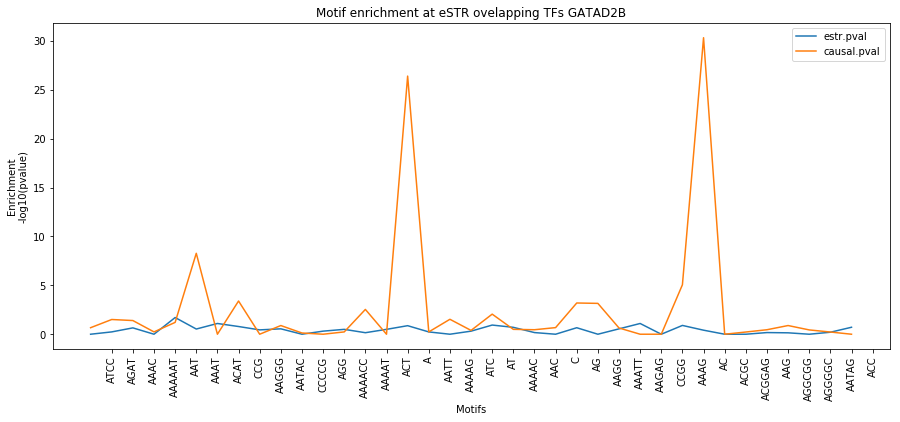

36


In [11]:
data = plotmotifenrichmentatTF('GATAD2B')
#Motif enrichment by tissue
#background = all STR at TF           foreground motif enriched at eSTR 
Mset,O,Mapdata,pdata = getfisher(data,TISSUES)
df1 = pd.DataFrame(pdata)
df1.index = [SHORTEN[t] for t in TISSUES]
df1.columns = Mset

GATAD2B
All STRs:  2512 	All TFs STRs:  2512 	All eSTRs:  418 	All Causal:  103


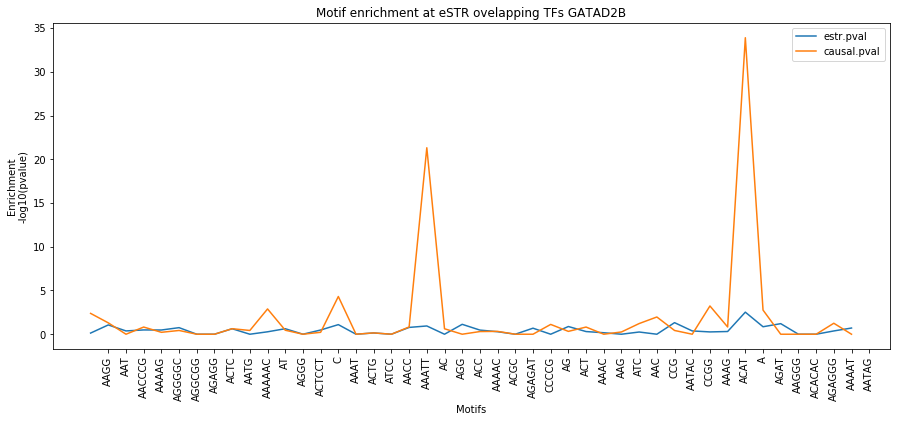

36


In [27]:
data = plotmotifenrichmentatTF('GATAD2B')
#Motif enrichment by tissue
#background = all STR at TF           foreground motif enriched at eSTR 
Mset,O,Mapdata,pdata = getfisher(data,TISSUES)
df1 = pd.DataFrame(pdata)
df1.index = [SHORTEN[t] for t in TISSUES]
df1.columns = Mset

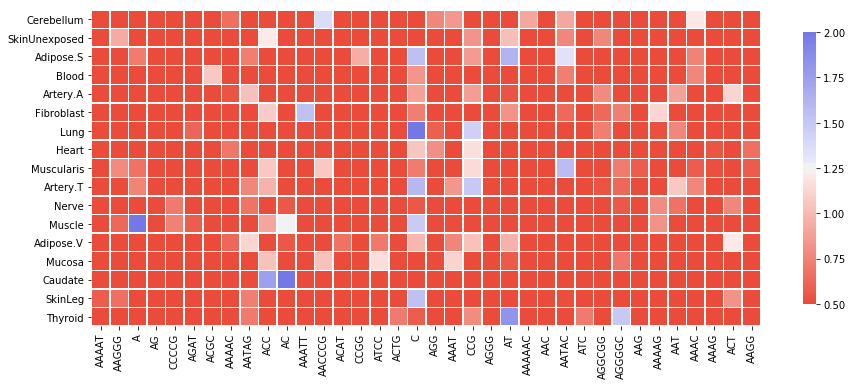

In [28]:
#plot enricment (-log10(pvalue) Fisher test)
fig, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(df1, cmap=cmap, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5});
ax.invert_xaxis();
plt.show()

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log2


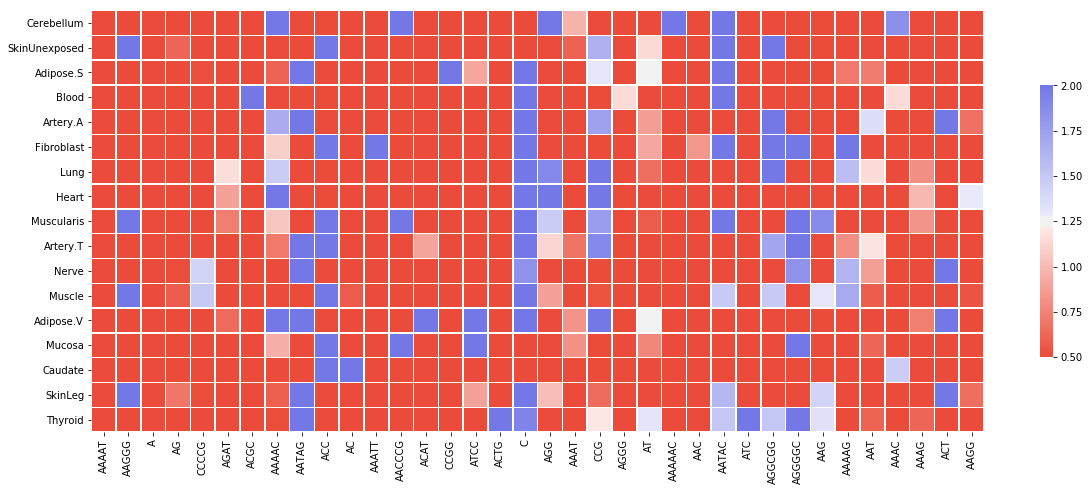

In [29]:
#plot enricment  log2(odd ratio) of fisher test
odds = np.zeros((len(TISSUES), len(Mset)))
for i in range(len(TISSUES)):
    T = TISSUES[i]
    for j in range(len(Mset)):
        m=Mset[j]
        val = [np.log2(s[3]) for s in  Mapdata[T] if s[0]==m ]
        if val==[]:
            odds[i][j] =0
        else:
            odds[i][j] =val[0]
#
df = pd.DataFrame(odds)
df.index = [SHORTEN[t] for t in TISSUES]
df.columns = Mset
fig, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(df, cmap=cmap, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5});
ax.invert_xaxis();
plt.show()

In [ ]:
#plot example